In [14]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("Imports OK")


Imports OK


In [15]:
# Load data

df = pd.read_csv("/Users/theresiacate/cheminformatics-portfolio/solubility-prediction/data/esol.csv")
print(df.shape)
df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [16]:
# Convert SMILES to RDKit molecules
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)

# Check how many molecules failed (should be very few or zero)
print("Total rows:", len(df))
print("Invalid molecules:", df["mol"].isna().sum())

df.head()


Total rows: 1128
Invalid molecules: 0


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x307723760>
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x3085a1a80>
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x3085a1bd0>
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x3085a1c40>
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x3085a1d20>


In [17]:
# Remove invalid molecules (data cleaning): Drop invalid molecules if any
df = df[df["mol"].notna()].reset_index(drop=True)

print("Clean dataset size:", df.shape)


Clean dataset size: (1128, 11)


In [18]:
# Check column

df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles', 'mol'],
      dtype='object')

In [19]:
# Calculate molecular descriptors (QSAR features)

# Function to calculate descriptors
def calc_descriptors(mol):
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RotBonds": Descriptors.NumRotatableBonds(mol),
        "Rings": Descriptors.RingCount(mol)
    })

# Apply to dataset
X = df["mol"].apply(calc_descriptors)

# Target variable
y = df["measured log solubility in mols per litre"]

print(X.shape)
X.head()


(1128, 7)


,MolWt,LogP,TPSA,HBD,HBA,RotBonds,Rings
0,457.432,-3.10802,202.32,7.0,12.0,7.0,3.0
1,201.225,2.84032,42.24,1.0,2.0,2.0,2.0
2,152.237,2.87800,17.07,0.0,1.0,4.0,0.0
3,278.354,6.29940,0.00,0.0,0.0,0.0,5.0
4,84.143,1.74810,0.00,0.0,1.0,0.0,1.0


In [20]:
# Split data and train the model


# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a simple QSAR model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2:", round(r2, 3))
print("RMSE:", round(rmse, 3))


# Model quality R² ~0.6–0.8 → good for a baseline QSAR
# Scientific meaning: MolWt, LogP, TPSA strongly influence solubility, 
# More polar + smaller molecules → higher solubility

R2: 0.861
RMSE: 0.811


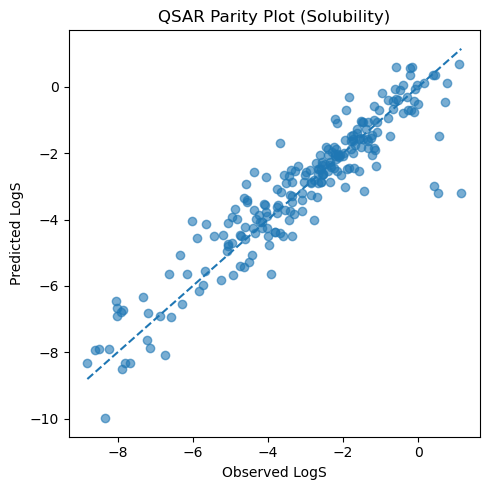

In [21]:
# Plot predicted vs observed LogS (QSAR parity plot)


plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Observed LogS")
plt.ylabel("Predicted LogS")
plt.title("QSAR Parity Plot (Solubility)")
plt.tight_layout()
plt.show()


In [22]:
# Scientific explanation: Compute and view feature importance


feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importance


LogP        0.816240
MolWt       0.100599
TPSA        0.043292
Rings       0.011823
RotBonds    0.010888
HBA         0.010626
HBD         0.006532
dtype: float64

Scientific explanation: Compute and view feature importance

1 LogP (lipophilicity)
Most important for solubility
High LogP → hydrophobic → low solubility
Low LogP → hydrophilic → high solubility

2 Molecular Weight (MolWt)
Larger molecules dissolve worse
Smaller molecules pack better with solvent
📉 As MolWt ↑ → LogS ↓

3️ TPSA (Topological Polar Surface Area)
Measures polarity
Higher TPSA → better hydrogen bonding with water
📈 TPSA ↑ → LogS ↑

4️ HBD / HBA (Hydrogen bond donors/acceptors)
Enable strong solute–solvent interactions
Improve aqueous solubility

5️ Rotatable bonds / Rings
More rings → rigid, hydrophobic → ↓ solubility
More rotatable bonds → mixed effect (entropy vs flexibility)

In [23]:
# Improve the model scientifically (cross-validation & tuning)
# 1. Add cross-validation (model reliability)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("CV R2 scores:", cv_scores)
print("Mean CV R2:", round(cv_scores.mean(), 3))
print("Std CV R2:", round(cv_scores.std(), 3))


# Mean CV R² → true expected performance
# Std CV R² → model stability (lower is better)

CV R2 scores: [0.91407437 0.89526931 0.8976503  0.87489662 0.84812001]
Mean CV R2: 0.886
Std CV R2: 0.023


In [24]:
# Improve the model scientifically (cross-validation & tuning)
# 2. Tune the Random Forest (proper QSAR tuning)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 3, 5]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X, y)

print("Best CV R2:", round(grid.best_score_, 3))
print("Best parameters:", grid.best_params_)


# Finds a better bias–variance balance, Avoids overfitting, Improves scientific robustness

Best CV R2: 0.887
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}


In [25]:
# Improve the model scientifically
# 3. Retrain the improved QSAR model

# Use the best model from grid search
best_model = grid.best_estimator_

# Train–test split again (same as before for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the improved model
best_model.fit(X_train, y_train)

# Predict
y_pred_best = best_model.predict(X_test)

# Evaluate
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Improved R2:", round(r2_best, 3))
print("Improved RMSE:", round(rmse_best, 3))


# R² equal to or higher than before (before 0.861)
# RMSE equal to or lower than before (before 0.811)
# This confirms real improvement, not noise.

Improved R2: 0.862
Improved RMSE: 0.809


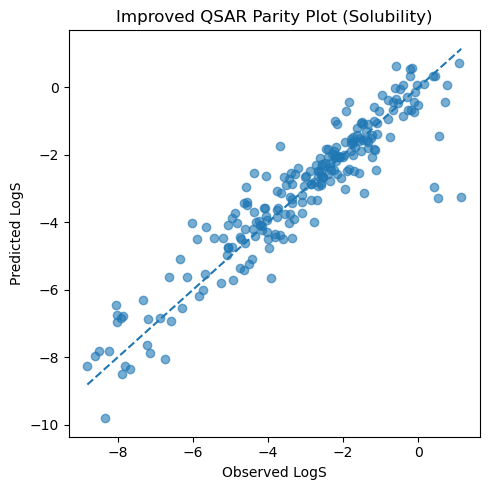

In [26]:
# Improve the model scientifically
# 4. Improved parity plot (final QSAR figure)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)

plt.xlabel("Observed LogS")
plt.ylabel("Predicted LogS")
plt.title("Improved QSAR Parity Plot (Solubility)")
plt.tight_layout()
plt.show()


# final scientific QSAR figure: A cleaner scatter & Points closer to the diagonal than before

In [27]:
# Save the trained model and results (portfolio-ready)
# 1. Save the trained QSAR model to disk

import joblib
import os

# Create models folder if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the trained model
joblib.dump(best_model, "../models/qsar_solubility_rf.joblib")

print("Model saved to models/qsar_solubility_rf.joblib")


Model saved to models/qsar_solubility_rf.joblib


In [28]:

# Save the trained model and results (portfolio-ready)
# 2. Save performance metrics (R², RMSE)

import json

metrics = {
    "R2": float(r2_best),
    "RMSE": float(rmse_best)
}

os.makedirs("../reports", exist_ok=True)

with open("../reports/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Metrics saved to reports/metrics.json")


Metrics saved to reports/metrics.json


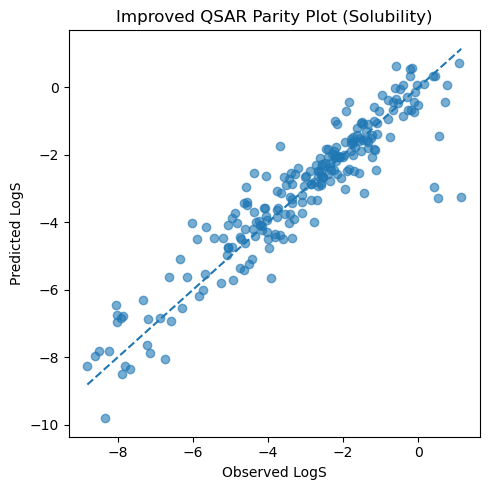

Figure saved to reports/figures/qsar_parity_plot.png


In [29]:
# Save the trained model and results (portfolio-ready)
# 3. Save the parity plot figure

import matplotlib.pyplot as plt
import os

# Ensure figures folder exists
os.makedirs("../reports/figures", exist_ok=True)

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)

plt.xlabel("Observed LogS")
plt.ylabel("Predicted LogS")
plt.title("Improved QSAR Parity Plot (Solubility)")
plt.tight_layout()

plt.savefig("../reports/figures/qsar_parity_plot.png", dpi=300)
plt.show()

print("Figure saved to reports/figures/qsar_parity_plot.png")
